Converged at step 585, angle=44.803


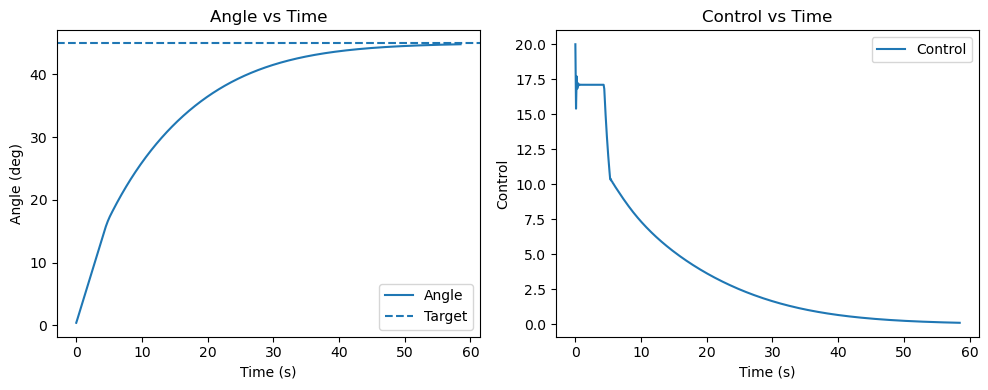

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#triangular membership (for scalars)
def trimf(x, a, b, c):
    #handle float tolerance for equality
    eps = 1e-9
    
    if x <= a or x >= c:
        return 0.0
    if abs(x - b) < eps:
        return 1.0
    if x < b:
        #avoid division by 0 (if a==b)
        return 0.0 if abs(b - a) < eps else (x - a) / (b - a)
    else:
        # avoid division by 0 (if b==c)
        return 0.0 if abs(c - b) < eps else (c - x) / (c - b)

#define fuzzy sets 
def err_neg(x): 
    return trimf(x, -180.0, -90.0, 0.0)

def err_zero(x): 
    return trimf(x, -30.0, 0.0, 30.0)

def err_pos(x): 
    return trimf(x, 0.0, 90.0, 180.0)

# derivative ranges (deg/s)
def derr_neg(x): 
    return trimf(x, -50.0, -25.0, 0.0)

def derr_zero(x): 
    return trimf(x, -5.0, 0.0, 5.0)

def derr_pos(x): 
    return trimf(x, 0.0, 25.0, 50.0)

#control o/p for defuzzification
u_universe = np.linspace(-50, 50, 501)

#membership func for control 
def u_sn(x): 
    return trimf(x, -50.0, -50.0, -25.0)

def u_wn(x): 
    return trimf(x, -40.0, -20.0, 0.0)

def u_z(x):  
    return trimf(x, -10.0, 0.0, 10.0)

def u_wp(x): 
    return trimf(x, 0.0, 20.0, 40.0)

def u_sp(x): 
    return trimf(x, 25.0, 50.0, 50.0)

#rule evaluation (Mamdani inference)
def evaluate_rules(e_val, de_val):
    
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    fired = []
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

#aggregate and defuzzify
def aggregate(fired, u_univ):
    agg = np.zeros_like(u_univ)
    
    for strength, mf_func in fired:
        if strength <= 0: continue
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    
    return agg

def defuzz_centroid(combined_mf, u_univ):
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    
    if den == 0: 
        return 0.0
    
    return num / den

#simulation
target_angle = 45.0
cur_angle = 0.0
dt = 0.1
gain = 0.2        
max_steps = 800
control_sat = 50.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)'); plt.title('Angle vs Time'); plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control'); plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
---------- Fuzzy controller: short, exam-style explanation (copy-paste as comments) ----------
1) Purpose of the script
This code implements a simple Mamdani fuzzy PD-like controller to drive cur_angle to target_angle.
It converts crisp error (e = target - current) and derivative of error (de) into a fuzzy control output,
then defuzzifies to a single numeric u_out that is applied to update the angle.

2) Imports and basic settings
- numpy: numerical arrays and linspace
- matplotlib: to plot angle and control histories
- key parameters:
* dt = 0.1 : simulation time step (seconds)
* gain = 0.2 : how much control affects the angle (scale factor)
* control_sat = 50.0 : saturates control to [-50, 50]
* u_universe = np.linspace(-50, 50, 501) : discrete domain for control membership functions

3) Triangular membership function (trimf)
- trimf(x,a,b,c) returns the degree of membership of x in a triangular fuzzy set with base [a,c] and peak b.
- returns 0 outside [a,c], 1 at b, linear slope between a->b and b->c.
- special handling to avoid division by zero when a==b or b==c.

4) Fuzzy sets for inputs
Error (e) fuzzy sets:
- err_neg : triangular covering large negative errors (a=-180, b=-90, c=0)
- err_zero: small errors around zero (a=-30, b=0, c=30)
- err_pos : positive errors (a=0, b=90, c=180)
Derivative (de) fuzzy sets:
- derr_neg , derr_zero , derr_pos with ranges chosen for typical deg/s values
These map the continuous e and de into membership degrees in linguistic terms: Negative, Zero, Positive.

5) Control output fuzzy sets (u_xxx)
- u_sn (strong negative), u_wn (weak negative), u_z (zero), u_wp (weak positive), u_sp (strong positive)
- Each u_* is also a triangular function defined over the control universe [-50, 50].
These are the output linguistic terms that will be clipped and aggregated during inference.

6) Rule evaluation (Mamdani inference) — evaluate_rules(e, de)
- Compute membership degrees for e and de in their three sets each.
- Nine rules are hardcoded (3x3 grid). Each rule uses min() to compute the firing strength:
firing_strength = min( membership_of(e, X), membership_of(de, Y) )
This implements fuzzy AND.
- Each fired rule returns a tuple: (firing_strength, output_membership_function)
Example rules (in plain words):
* If e is Negative AND de is Negative -> output = Strong Negative (u_sn)
* If e is Zero AND de is Zero -> output = Zero (u_z)
* If e is Positive AND de is Positive -> output = Strong Positive (u_sp)
and so on for all combinations.

7) Aggregation (aggregate)
- For each fired rule with strength > 0, the corresponding output membership function is clipped
at that firing strength: clipped_mf(u) = min(firing_strength, u_term(u)).
- Aggregation across all rules is performed by taking the pointwise maximum of clipped MFs.
- The result is a combined fuzzy set on the control universe.

8) Defuzzification (defuzz_centroid)
- The centroid (center of gravity) method is used:
u_out = sum(combined_mf(u) * u) / sum(combined_mf(u))
computed discretely across u_universe.
- If denominator is zero (no rule fired), returns 0.0.

9) Simulation loop
- prev_error initialized to target - cur_angle (so initial de = 0 on first iteration).
- For each step:
* e = target - cur_angle
* de = (e - prev_error) / dt
* evaluate_rules(e, de) -> get list of fired rules
* aggregate -> combined fuzzy output
* defuzz_centroid -> u_out (crisp control)
* saturate control: clip u_out to [-control_sat, control_sat]
* update angle: cur_angle += gain * u_out * dt
* record time, angle, control histories
* check convergence: stop if |e| < 0.2 AND |de| < 0.5
- max_steps prevents infinite loops.

10) Key numerical design choices and their effect
- gain multiplies the control action before integrating into angle. Smaller gain → slower response,
larger gain → faster movement but more risk of overshoot/oscillations.
- control_sat limits the maximum possible control action.
- u_universe resolution (501 samples) controls accuracy of centroid calculation.
- The triangular membership shapes and rule base determine how aggressive the controller is for
given errors and derivatives.

11) Plotting
- Left plot (Angle vs Time): shows how the angle approaches the dashed line (target).
- Right plot (Control vs Time): shows the numeric u_out applied at every time step.

    ---------- Interpretation of the printed output and plots ----------
The program printed:
Converged at step 585, angle=44.803
This means:
- At step 585 (time = 585 * dt = 585 * 0.1 = 58.5 seconds) the convergence condition was met.
- The controller stopped because the remaining error |target - cur_angle| was smaller than 0.2 deg
and the derivative of the error was smaller than 0.5 deg/s.
- Final angle = 44.803 deg, so the steady-state error is target - angle ≈ 0.197 deg (very small).

Observations you can describe in viva:
- The angle approaches the target smoothly — no large sustained oscillations — indicating a stable fuzzy controller.
- The control signal typically starts larger when the error is large, then decays towards zero as the error reduces.
- The response is relatively slow: it takes ~58.5 s to reach the convergence band. This slowness comes from
the combined effect of moderate gain (0.2), the way rules map e/de to relatively conservative output mfs,
and centroid defuzzification which produces smooth (not bang-bang) outputs.
- Small steady-state error (~0.2 deg) occurs because with these membership functions and gain the controller
produces just enough control to settle inside the tolerance. This is normal for a PD-like behavior without an integral term.

12) Practical exam points / why the design is reasonable
- Mamdani inference and centroid defuzzification yield intuitive, human-like control actions (smooth control).
- Triangular MFs are simple and cheap to compute for an embedded or real-time setup.
- The rule base is symmetric and easy to explain: positive error → positive control, negative → negative, zero → small/no control.

13) Short answers to likely viva questions
Q: Why use fuzzy instead of a classical PID here?
A: Fuzzy gives rule-based, interpretable control that handles nonlinearities and uncertainty; it needs no exact model.
Q: What does the centroid do?
A: Computes the weighted average (center) of the aggregated fuzzy output to produce a single crisp control value.
Q: How to make it faster / reduce steady error?
A: Increase gain, widen/reshape output membership functions for larger outputs at moderate errors, or add an
integral-like fuzzy rule (or a small integral term) to remove steady-state error. Be careful — increasing gain
can cause overshoot or oscillation; tune membership functions and rules accordingly.
Q: Why check de (derivative) in rules?
A: de provides damping and anticipatory action: if error is decreasing fast, controller can reduce output to avoid overshoot.
---------- End of comment block ----------

In [ ]:
# =================== DETAILED THEORY (COMMENT FORMAT FOR JUPYTER) ===================
# ---------------------- 1. What is Fuzzy Logic? ----------------------
# Fuzzy logic extends classical (true/false) logic by allowing degrees of truth between 0 and 1.
# It is used when system behavior is uncertain, nonlinear, or cannot be expressed with strict equations.
# Instead of exact mathematical control laws, fuzzy logic uses human-like rules such as:
#     "If error is Positive and change in error is Negative → apply Strong Positive control"
# This makes fuzzy controllers intuitive, robust to noise, and flexible.

# ---------------------- 2. Fuzzy Sets & Membership Functions (MFs) ----------------------
# A fuzzy set A is defined by a membership function μ_A(x) that returns how strongly x belongs to set A.
# μ(x) ranges from 0 (not a member) to 1 (full membership).
# Triangular MFs (used in the code) are simple and widely used because:
# - They need only 3 parameters (a, b, c)
# - They are computationally efficient (just linear segments)
# The triangular MF formula:
#   μ(x) = (x-a)/(b-a) for x in (a,b)
#   μ(x) = (c-x)/(c-b) for x in (b,c)
#   μ(x) = 1 at x = b, and 0 outside [a,c]

# ---------------------- 3. Fuzzification ----------------------
# Fuzzification converts crisp numeric values (error e, derivative de) into fuzzy degrees.
# Example:
#   If e = 40°, and MF for Positive Error peaks around 90°, 
#   then μ_Positive(e) may be around 0.4, meaning “moderately positive.”
# In the code, each input is evaluated against 3 fuzzy sets:
# - Error: Negative, Zero, Positive
# - Derivative of Error: Negative, Zero, Positive

# ---------------------- 4. Rule Base (Fuzzy IF–THEN Rules) ----------------------
# Rules link fuzzy inputs to fuzzy outputs.
# General structure:
#    IF (e is A) AND (de is B) THEN (control is C)
# The code has a 3x3 rule base (9 rules), e.g.:
# - If e is Negative AND de is Negative → Strong Negative control
# - If e is Zero AND de is Zero → Zero control
# - If e is Positive AND de is Positive → Strong Positive control
# The AND operation between membership values is implemented using min().

# ---------------------- 5. Mamdani Inference ----------------------
# Mamdani is one of the most common inference methods.
# Steps:
# 1. Rule firing strength:
#       α = min( μ_A(e), μ_B(de) )
# 2. Apply α to output MF by clipping:
#       μ_output_clipped(u) = min( α, μ_output(u) )
# 3. Aggregate contributions from all rules by taking pointwise max:
#       μ_agg(u) = max( μ_rule1(u), μ_rule2(u), ... )
# The result is a single fuzzy set μ_agg(u) over the output universe.

# ---------------------- 6. Defuzzification (Centroid Method) ----------------------
# Defuzzification converts the aggregated fuzzy output into a crisp value.
# The code uses the Centroid (Center of Gravity) method:
#      u_out = sum( μ_agg(u) * u ) / sum( μ_agg(u) )
# The centroid:
# - Produces smooth continuous output
# - Is widely used in control systems
# If denominator is zero (no rule fired), output defaults to 0.

# ---------------------- 7. Nature of the Controller (Fuzzy PD-like Control) ----------------------
# The controller behaves similarly to a PD controller:
# - Error (e) → proportional action (larger error → larger control)
# - Derivative (de) → damping/anticipation (prevents overshoot)
# There is no integral term, so a small steady-state error may remain.

# ---------------------- 8. Numerical System Update ----------------------
# The angle is updated using simple Euler integration:
#     cur_angle(t+dt) = cur_angle(t) + gain * u_out * dt
# Here:
# - gain controls overall responsiveness
# - dt is the simulation timestep
# This models a plant where control directly influences angular velocity.

# ---------------------- 9. Control Saturation ----------------------
# Output control is limited to [-50, +50].
# Saturation prevents unrealistic control values.
# However, saturation can introduce small steady-state errors in PD-style controllers.

# ---------------------- 10. Convergence Criteria ----------------------
# Simulation stops when:
# - |error| < 0.2 degrees
# - |derivative| < 0.5 degrees/sec
# This indicates the system is close to stability and not changing rapidly.

# ---------------------- 11. Interpretation of Output Behavior ----------------------
# The print message:
#       "Converged at step 585, angle=44.803"
# means:
# - It took ~58.5 seconds to reach near the target angle (45°).
# - Final angle is 44.803°, so steady-state error ≈ 0.197° (very small).
# The "Angle vs Time" plot shows:
# - A smooth rise with no oscillation → indicates stable control.
# - Slow but steady convergence due to moderate gain and fuzzy rule behavior.
# The "Control vs Time" plot shows:
# - High control initially when error is large
# - Control gradually decreases to near 0 as error shrinks

# ---------------------- 12. Factors Affecting Performance ----------------------
# 1. Membership Function Shape:
#    Wide MFs → smoother but slower control
#    Narrow MFs → more aggressive response
# 2. Gain:
#    Higher gain → faster response but can cause overshoot
# 3. Rule Base:
#    Changing rules can make controller more/less aggressive
# 4. Output MF scaling:
#    Larger ranges → bigger control → faster convergence

# ---------------------- 13. How to Improve Speed or Accuracy ----------------------
# - Increase gain (carefully)
# - Increase output MF ranges (u_sp, u_wp, etc.)
# - Add an integral-like term (fuzzy or conventional)
# - Reduce dt for more accurate simulation
# - Redesign rule base for stronger correction when error is moderate

# ---------------------- 14. Why Fuzzy Controllers Are Useful ----------------------
# - They do not require a precise mathematical model of system dynamics
# - They can handle nonlinearities automatically
# - Rules are interpretable and resemble human reasoning
# - Often more robust to noise compared to classical controllers

# ====================================================================
